# **Import Libraries + Configurations**

In [1]:
# =========
# Libraries
# =========

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import json

from pathlib import Path
from sklearn.model_selection import GroupShuffleSplit
from tqdm.auto import tqdm


# =======
# Configs
# =======

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

DATA_DIR = Path('/kaggle/input/birdclef-2024')
OUT_DIR = Path('/kaggle/working/preprocessed')
OUT_DIR.mkdir(exist_ok=True, parents=True)

AUDIO_DIR = DATA_DIR / 'train_audio'

# Audio parameters
SR = 32000 # target sampling rate (samples per second). Files may be resampled to this rate.
TARGET_SEC = 5.0 # length (in seconds) each example should be (commonly used to pad / crop audio to fixed-size windows).

# spectrogram STFT parameters: N_FFT is the window size for each FFT, and HOP is the hop length (time step between frames).
N_FFT = 2048 # ~64ms window at 32k Hz
HOP = 512 # ~16ms step

N_MELS = 128 # number of Mel bands when computing Mel spectrograms; common input for audio models.

# Choose top classes
TOP_N = 10

# Dataset split proportions
TRAIN_PCT = 0.70
VAL_PCT   = 0.15
TEST_PCT  = 0.15

# Augmentation hyperparams
MAX_PITCH_STEPS = 2.0
STRETCH_MIN = 0.85
STRETCH_MAX = 1.15
NOISE_STD = 0.005

# **Load metadata + Choose Top-N classes**

In [2]:
df = pd.read_csv(DATA_DIR / 'train_metadata.csv')
# value_counts() counts how many rows for each species (i.e., frequency of each label).
# By default value_counts sorts descending so the most common labels come first.
counts = df['primary_label'].value_counts()

# nunique() prints how many distinct species appear in the dataset.
print("Total species:", df['primary_label'].nunique())
print("\nTop 30 species by frequency:")
print(counts.head(30))

Total species: 182

Top 30 species by frequency:
primary_label
hoopoe     500
grewar3    500
houspa     500
blrwar1    500
grnsan     500
comgre     500
graher1    500
litgre1    500
eurcoo     500
comkin1    500
lirplo     500
eucdov     500
eaywag1    500
woosan     500
zitcis1    500
barswa     500
bcnher     500
comros     500
commoo3    500
grywag     500
comsan     500
bkwsti     500
rorpar     420
litegr     405
comtai1    302
grtdro1    278
greegr     276
asikoe2    275
purher1    274
wemhar1    273
Name: count, dtype: int64


In [3]:
# Select the TOP_N most common species

# takes the top TOP_N most frequent species and stores their label names in selected.
selected = counts.head(TOP_N).index.tolist()
print(f"\nSelected top-{TOP_N} species: {selected}")

# Filter metadata to only include these classes

# filters the DataFrame to only rows whose primary_label is in the selected list (and .copy() makes an explicit copy to avoid SettingWithCopy warnings).
# Using .copy() is a good practice when you will modify the filtered DataFrame
filtered = df[df['primary_label'].isin(selected)].copy()

# filtered['filename'].notna() removes rows where filename is missing (ensures we only keep entries that have an audio file name).
# reset_index(drop=True) resets the DataFrame index (nice housekeeping so indices run 0..n-1 after filtering).
filtered = filtered[filtered['filename'].notna()].reset_index(drop=True) 

print("\nFiltered shape:", filtered.shape)
print("Class distribution in filtered:")
print(filtered['primary_label'].value_counts()) # The subsequent value_counts() prints the class distribution inside the filtered subset.


Selected top-10 species: ['hoopoe', 'grewar3', 'houspa', 'blrwar1', 'grnsan', 'comgre', 'graher1', 'litgre1', 'eurcoo', 'comkin1']

Filtered shape: (5000, 12)
Class distribution in filtered:
primary_label
blrwar1    500
comgre     500
comkin1    500
eurcoo     500
graher1    500
grewar3    500
grnsan     500
hoopoe     500
houspa     500
litgre1    500
Name: count, dtype: int64


# **Check missing files**

In [4]:
missing = []
for fn in filtered['filename'].unique():
    if not (AUDIO_DIR / fn).exists():
        missing.append(fn)

print("Missing audio files:", len(missing))
if len(missing) > 0:
    print("Example missing:", missing[:10])
else:
    print("All audio files found.")

Missing audio files: 0
All audio files found.


# **Data Splitting based on Groups ("Author")**

# **Compute group IDs**

**This constructs an array called groups that will be used to split the data while keeping samples from the same group together (so the same author doesn’t appear in both train and validation sets). If author is missing, filename is used as a fallback group id. Group-aware splitting prevents data leakage when multiple examples from the same real-world source exist. GroupShuffleSplit (imported earlier) is the tool you’d typically use to perform such group-based splits. 
Scikit-learn**

In [5]:
# Use 'author' to avoid leakage between train/val/test
# If author is missing, use filename as fallback

groups = filtered['author'].fillna(filtered['filename']).values
print("Example groups:", groups[:10])

Example groups: ['Patrik Åberg' 'Edmunds Racinskis' 'Edmunds Racinskis'
 'Edmunds Racinskis' 'Antero Lindholm' 'Patrick Franke' 'Patrick Franke'
 'Lars Theng' 'Antero Lindholm' 'Albert Lastukhin']


# **Split 1: TrainVal / Test**

In [6]:
splitter1 = GroupShuffleSplit(
    n_splits=1, 
    test_size=TEST_PCT, 
    random_state=SEED
)

trainval_idx, test_idx = next(
    splitter1.split(
        filtered,
        filtered['primary_label'],
        groups
    )
)

trainval_df = filtered.iloc[trainval_idx].reset_index(drop=True)
test_df     = filtered.iloc[test_idx].reset_index(drop=True)

In [7]:
print("TrainVal shape:", trainval_df.shape)
print("Test shape:", test_df.shape)

TrainVal shape: (4005, 12)
Test shape: (995, 12)


# **Split 2: Train / Validation**

In [8]:
# val proportion relative to TrainVal only
val_rel = VAL_PCT / (1.0 - TEST_PCT)

splitter2 = GroupShuffleSplit(
    n_splits=1, 
    test_size=val_rel, 
    random_state=SEED
)

groups_trainval = trainval_df['author'].fillna(trainval_df['filename']).values

train_idx_rel, val_idx_rel = next(
    splitter2.split(
        trainval_df,
        trainval_df['primary_label'],
        groups_trainval
    )
)

train_df = trainval_df.iloc[train_idx_rel].reset_index(drop=True)
val_df   = trainval_df.iloc[val_idx_rel].reset_index(drop=True)

In [9]:
print("Train shape:", train_df.shape)
print("Val shape:", val_df.shape)

Train shape: (3037, 12)
Val shape: (968, 12)


# **Save splits + sanity checks**

In [10]:
train_df.to_csv(OUT_DIR / 'train_meta_top10.csv', index=False)
val_df.to_csv(OUT_DIR / 'val_meta_top10.csv', index=False)
test_df.to_csv(OUT_DIR / 'test_meta_top10.csv', index=False)

In [11]:
print("Saved train/val/test metadata!")

print("\nPer-class counts — TRAIN:")
print(train_df['primary_label'].value_counts().sort_index())

print("\nPer-class counts — VALIDATION:")
print(val_df['primary_label'].value_counts().sort_index())

print("\nPer-class counts — TEST:")
print(test_df['primary_label'].value_counts().sort_index())

# Makeup check
print("\nCheck total rows:",
      len(train_df) + len(val_df) + len(test_df),
      "== filtered size:", len(filtered))

Saved train/val/test metadata!

Per-class counts — TRAIN:
primary_label
blrwar1    349
comgre     322
comkin1    220
eurcoo     325
graher1    319
grewar3    363
grnsan     311
hoopoe     257
houspa     250
litgre1    321
Name: count, dtype: int64

Per-class counts — VALIDATION:
primary_label
blrwar1     60
comgre      80
comkin1    178
eurcoo      72
graher1     98
grewar3     53
grnsan     106
hoopoe     123
houspa     121
litgre1     77
Name: count, dtype: int64

Per-class counts — TEST:
primary_label
blrwar1     91
comgre      98
comkin1    102
eurcoo     103
graher1     83
grewar3     84
grnsan      83
hoopoe     120
houspa     129
litgre1    102
Name: count, dtype: int64

Check total rows: 5000 == filtered size: 5000


# **Preprocess + Feature Extraction + Augmentation Funs**

In [12]:
# Load audio (mono), resample, pad/crop to target_sec and RMS-normalize.
def load_and_fix_length(path, sr=SR, target_sec=TARGET_SEC):
    y, _sr = sf.read(path) 
    # Reads the audio file at path into a NumPy array y and returns the file’s original sample rate _sr.
    #This uses the PySoundFile (soundfile) library which returns NumPy arrays.
    
    # Convert to mono (from 2 channels to one channel)
    if y.ndim > 1:
        # y = y.mean(axis=1)
        y = librosa.to_mono(y.T) # y.T converts from (n_samples, n_channels) → (n_channels, n_samples),
    
    # Resampling: if the original sample rate _sr differs from desired sr (e.g. 44100 → 32000), resample the waveform to sr.
    # This uses librosa.resample which performs high-quality band-limited resampling. 
    # Resampling ensures all examples have the same temporal resolution for later features.
    if _sr != sr:
        y = librosa.resample(y.astype('float32'), orig_sr=_sr, target_sr=sr)
    
    # Compute the target number of samples for target_sec seconds (e.g. 32000 * 5 = 160000 samples).
    target_len = int(sr * target_sec)

    # Padding
    # Pad short audio with zeros at the end so every clip becomes target_len.
    # np.pad with mode='constant' fills zeros; useful because most neural nets need fixed-length inputs.
    if len(y) < target_len:
        pad = target_len - len(y)
        y = np.pad(y, (0, pad), mode='constant')

    # Crop long audio: instead of taking a fixed slice, it performs a random crop — that adds data 
    # variability/augmentation during preprocessing (different crops across epochs → more robustness).
    elif len(y) > target_len:
        # random crop for variability
        start = np.random.randint(0, len(y)-target_len+1)
        y = y[start:start+target_len]

    # RMS normalization
    # compute the root-mean-square (RMS) amplitude sqrt(mean(y^2)) and divide the signal by it so each clip has approximately the same average energy. 
    # Adding 1e-9 prevents division by zero for silent files. RMS (average-power) normalization is common when you want consistent loudness between samples (different from peak normalization).
    rms = np.sqrt(np.mean(y**2)) + 1e-9
    y = y / rms
    return y.astype('float32')

In [13]:
# Return log-mel (n_mels x frames) as float32.
def extract_log_mel(y, sr=SR, n_fft=N_FFT, hop_length=HOP, n_mels=N_MELS):
    # librosa.feature.melspectrogram computes a Mel-scaled spectrogram from the waveform. With power=2.0, it computes a power spectrogram (energy; magnitude squared).
    # Mel scale compresses frequency bins to match human perception and is the standard input for many audio NN models.
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=2.0)
    
    # librosa.power_to_db converts the power spectrogram to decibels (log scale), which both compresses dynamic range and tends to work better for models than linear power.
    # It computes 10 * log10(S / ref) in a numerically stable way.
    logS = librosa.power_to_db(S, ref=np.max)
    return logS.astype('float32')

# **Extract original TRAIN log-mels directly into features_mel/Train**

In [14]:
# Ensure necessary vars exist
if 'train_df' not in globals():
    train_df = pd.read_csv(OUT_DIR / 'train_meta_top10.csv')

FEAT_DIR = OUT_DIR / 'features_mel'
train_dir = FEAT_DIR / 'Train'
for d in (FEAT_DIR, train_dir):
    Path(d).mkdir(parents=True, exist_ok=True)

orig_feat_csv = OUT_DIR / 'train_features_top10_original.csv'
orig_feat_records = []

if orig_feat_csv.exists():
    print("Original features CSV found — loading:", orig_feat_csv)
    orig_feat_df = pd.read_csv(orig_feat_csv)
    print("Rows loaded:", len(orig_feat_df))
else:
    print("No original features CSV found — extracting log-mel for train samples now...")
    for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
        fn = row['filename']
        path = AUDIO_DIR / fn
        try:
            y = load_and_fix_length(path)   # uses your existing helper
            m = extract_log_mel(y)          # uses your existing helper
            out_filename = Path(fn).stem + '.npy'
            out_path = train_dir / out_filename
            # skip if file already exists (idempotent)
            if not out_path.exists():
                np.save(out_path, m)
            orig_feat_records.append({
                'feature_path': str(out_path),
                'filename': fn,
                'primary_label': row['primary_label'],
                'is_augmented': 0
            })
        except Exception as e:
            print("Error on", fn, e)

    orig_feat_df = pd.DataFrame(orig_feat_records)
    orig_feat_df.to_csv(orig_feat_csv, index=False)
    print("Saved original train features metadata:", orig_feat_csv)
    print("Original train feature rows:", len(orig_feat_df))

No original features CSV found — extracting log-mel for train samples now...


  0%|          | 0/3037 [00:00<?, ?it/s]

Saved original train features metadata: /kaggle/working/preprocessed/train_features_top10_original.csv
Original train feature rows: 3037


# **Extract VALIDATION and TEST log-mels into separate subfolders**

In [15]:
# Ensure val_df / test_df present
assert 'val_df' in globals(), "val_df not found — run the split cells first"
assert 'test_df' in globals(), "test_df not found — run the split cells first"

FEAT_DIR = OUT_DIR / 'features_mel'
val_dir = FEAT_DIR / 'Validation'
test_dir = FEAT_DIR / 'Test'
for d in (FEAT_DIR, val_dir, test_dir):
    Path(d).mkdir(parents=True, exist_ok=True)

# Validation
val_records = []
print("Extracting log-mel for validation set... total rows:", len(val_df))
for idx, row in tqdm(val_df.iterrows(), total=len(val_df)):
    fn = row['filename']
    path = AUDIO_DIR / fn
    try:
        y = load_and_fix_length(path)
        m = extract_log_mel(y)
        out_name = f"{Path(fn).stem}_VAL.npy"
        out_path = val_dir / out_name
        if not out_path.exists():
            np.save(out_path, m)
        val_records.append({
            'feature_path': str(out_path),
            'filename': fn,
            'primary_label': row['primary_label'],
            'is_augmented': 0
        })
    except Exception as e:
        print("Error processing validation file:", fn, e)

val_feat_df = pd.DataFrame(val_records)
val_csv = OUT_DIR / 'val_features_top10.csv'
val_feat_df.to_csv(val_csv, index=False)
print("Saved validation features CSV:", val_csv)
print("Validation features extracted:", len(val_feat_df))

# Test
test_records = []
print("Extracting log-mel for test set... total rows:", len(test_df))
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    fn = row['filename']
    path = AUDIO_DIR / fn
    try:
        y = load_and_fix_length(path)
        m = extract_log_mel(y)
        out_name = f"{Path(fn).stem}_TEST.npy"
        out_path = test_dir / out_name
        if not out_path.exists():
            np.save(out_path, m)
        test_records.append({
            'feature_path': str(out_path),
            'filename': fn,
            'primary_label': row['primary_label'],
            'is_augmented': 0
        })
    except Exception as e:
        print("Error processing test file:", fn, e)

test_feat_df = pd.DataFrame(test_records)
test_csv = OUT_DIR / 'test_features_top10.csv'
test_feat_df.to_csv(test_csv, index=False)
print("Saved test features CSV:", test_csv)
print("Test features extracted:", len(test_feat_df))

Extracting log-mel for validation set... total rows: 968


  0%|          | 0/968 [00:00<?, ?it/s]

Saved validation features CSV: /kaggle/working/preprocessed/val_features_top10.csv
Validation features extracted: 968
Extracting log-mel for test set... total rows: 995


  0%|          | 0/995 [00:00<?, ?it/s]

Saved test features CSV: /kaggle/working/preprocessed/test_features_top10.csv
Test features extracted: 995


# **Augmentation**

In [16]:
# Apply one random augmentation: pitch / stretch / noise.
# Uses explicit librosa.effects calls to avoid shadowing issues.
def augment_audio(y, sr=SR):
    choice = random.choice(['pitch', 'stretch', 'noise'])
    if choice == 'pitch':
        steps = random.uniform(-MAX_PITCH_STEPS, MAX_PITCH_STEPS)
        try:
            y_aug = librosa.effects.pitch_shift(y.astype('float32'), sr, steps)
        except Exception:
            return y
        # keep same length
        if len(y_aug) < len(y):
            y_aug = np.pad(y_aug, (0, len(y)-len(y_aug)), mode='constant')
        else:
            y_aug = y_aug[:len(y)]
        return y_aug.astype('float32')

    elif choice == 'stretch':
        rate = random.uniform(STRETCH_MIN, STRETCH_MAX)
        try:
            y_st = librosa.effects.time_stretch(y.astype('float32'), rate)
        except Exception:
            return y
        if len(y_st) < len(y):
            y_st = np.pad(y_st, (0, len(y)-len(y_st)), mode='constant')
        else:
            y_st = y_st[:len(y)]
        return y_st.astype('float32')

    else:  # noise
        noise = np.random.normal(0, NOISE_STD, size=len(y)).astype('float32')
        return (y + noise).astype('float32')

# **Augment TRAIN set directly into features_mel/Train, save balanced CSV and class weights**

In [17]:
# Ensure train_df & orig_feat_df
if 'train_df' not in globals():
    train_df = pd.read_csv(OUT_DIR / 'train_meta_top10.csv')

orig_csv = OUT_DIR / 'train_features_top10_original.csv'
if Path(orig_csv).exists():
    orig_feat_df = pd.read_csv(orig_csv)
else:
    # If original CSV missing (maybe you ran cell1 but didn't save), try to build from files in Train dir
    train_dir = OUT_DIR / 'features_mel' / 'Train'
    orig_feat_df = []
    for p in Path(train_dir).glob('*.npy'):
        # Try to recover label from train_df by filename match
        fname = p.name
        # find corresponding filename in train_df
        match = train_df[train_df['filename'].apply(lambda x: Path(x).stem in fname)]
        label = match['primary_label'].iloc[0] if len(match) > 0 else ''
        orig_feat_df.append({'feature_path': str(p), 'filename': fname, 'primary_label': label, 'is_augmented': 0})
    orig_feat_df = pd.DataFrame(orig_feat_df)

# Directories
FEAT_DIR = OUT_DIR / 'features_mel'
train_dir = FEAT_DIR / 'Train'
train_dir.mkdir(parents=True, exist_ok=True)

# Determine target per-class
train_class_counts = train_df['primary_label'].value_counts()
TARGET_PER_CLASS = int(train_class_counts.max())
print("Target per class (max in train):", TARGET_PER_CLASS)

# Current original feature counts
curr_counts = orig_feat_df['primary_label'].value_counts().to_dict()
print("\nCurrent extracted original counts (may be <= train counts):")
print(pd.Series(curr_counts).sort_index())

aug_records = []
classes = sorted(train_df['primary_label'].unique())

print(f"\nAugmenting train only to reach {TARGET_PER_CLASS} samples per class (based on train_df)...")
for cls in tqdm(classes):
    curr = int(curr_counts.get(cls, 0))
    needed = TARGET_PER_CLASS - curr
    if needed <= 0:
        continue

    candidates = train_df[train_df['primary_label'] == cls]
    if candidates.empty:
        print("No train candidates for", cls, " — skipping.")
        continue

    sampled = candidates.sample(needed, replace=True, random_state=SEED).reset_index(drop=True)
    for _, row in sampled.iterrows():
        wav_path = AUDIO_DIR / row['filename']
        try:
            y = load_and_fix_length(wav_path)
            y_aug = augment_audio(y, SR)
            mel = extract_log_mel(y_aug)
            aug_stem = f"{Path(row['filename']).stem}_AUG_{random.randint(100000, 999999)}.npy"
            out_path = train_dir / aug_stem
            # ensure unique (very unlikely conflict)
            if out_path.exists():
                continue
            np.save(out_path, mel)
            aug_records.append({
                'feature_path': str(out_path),
                'filename': row['filename'],
                'primary_label': cls,
                'is_augmented': 1
            })
        except Exception as e:
            print("Error augmenting", wav_path, e)

aug_df = pd.DataFrame(aug_records)
print("Augmented feature rows created:", len(aug_df))

# Combine original + augmented -> balanced features CSV
# Make sure orig_feat_df feature_path points to Train dir files (if they are by filename)
def normalize_feature_path(p):
    if pd.isna(p) or p == '':
        return p
    p = Path(p)
    if p.exists():
        return str(p)
    # try to resolve by name inside train_dir
    candidate = train_dir / p.name
    if candidate.exists():
        return str(candidate)
    return str(p)

if 'feature_path' in orig_feat_df.columns:
    orig_feat_df['feature_path'] = orig_feat_df['feature_path'].apply(normalize_feature_path)

final_feat_df = pd.concat([orig_feat_df, aug_df], ignore_index=True).reset_index(drop=True)
balanced_csv = OUT_DIR / 'train_features_top10_balanced_by_maxclass.csv'
final_feat_df.to_csv(balanced_csv, index=False)
print("Saved balanced train features metadata:", balanced_csv)

# Final counts check and class weights
final_counts = final_feat_df['primary_label'].value_counts().sort_index()
print("\nFinal per-class counts (train) after augmentation:")
print(final_counts)

total = final_counts.sum()
class_weight = {label: (total / (len(final_counts) * int(cnt))) for label, cnt in final_counts.items()}
with open(OUT_DIR / 'class_weights_top10_by_maxclass.json', 'w') as f:
    json.dump(class_weight, f)
print("Saved class weights:", OUT_DIR / 'class_weights_top10_by_maxclass.json')

# Quick final distribution and plot
def count_npys(d):
    return len(list(Path(d).glob('*.npy')))

print("\nFinal distribution in subfolders:")
print(f" Train: {count_npys(train_dir)} files -> {train_dir}")
print(f" Validation: {count_npys(FEAT_DIR / 'Validation')} files -> {FEAT_DIR / 'Validation'}")
print(f" Test: {count_npys(FEAT_DIR / 'Test')} files -> {FEAT_DIR / 'Test'}")

Target per class (max in train): 363

Current extracted original counts (may be <= train counts):
blrwar1    349
comgre     322
comkin1    220
eurcoo     325
graher1    319
grewar3    363
grnsan     311
hoopoe     257
houspa     250
litgre1    321
dtype: int64

Augmenting train only to reach 363 samples per class (based on train_df)...


  0%|          | 0/10 [00:00<?, ?it/s]

Augmented feature rows created: 593
Saved balanced train features metadata: /kaggle/working/preprocessed/train_features_top10_balanced_by_maxclass.csv

Final per-class counts (train) after augmentation:
primary_label
blrwar1    363
comgre     363
comkin1    363
eurcoo     363
graher1    363
grewar3    363
grnsan     363
hoopoe     363
houspa     363
litgre1    363
Name: count, dtype: int64
Saved class weights: /kaggle/working/preprocessed/class_weights_top10_by_maxclass.json

Final distribution in subfolders:
 Train: 3630 files -> /kaggle/working/preprocessed/features_mel/Train
 Validation: 968 files -> /kaggle/working/preprocessed/features_mel/Validation
 Test: 995 files -> /kaggle/working/preprocessed/features_mel/Test


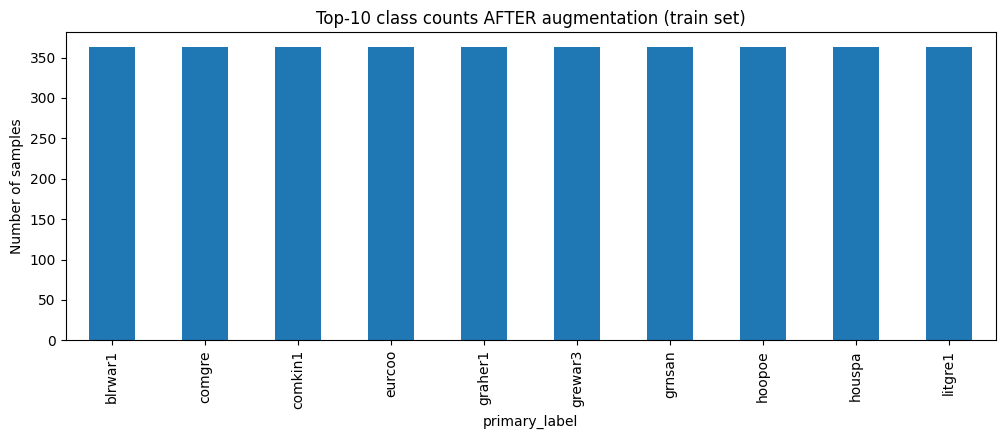

In [18]:
plt.figure(figsize=(12,4))
final_counts.sort_values(ascending=False).plot(kind='bar')
plt.title("Top-10 class counts AFTER augmentation (train set)")
plt.ylabel("Number of samples")
plt.xticks(rotation=90)
plt.show()

# VIT Transformer

In [19]:
# Full ViT training script with: EarlyStopping, ReduceLROnPlateau, SpecAugment,
# Dropout in head, optional MixUp, label smoothing, weight decay, and optional freezing.
# Comments are in English only.

import random
from pathlib import Path
import json
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights


In [20]:
# ------------------------
# Config / Hyperparameters
# ------------------------
OUT_DIR = Path("/kaggle/working/preprocessed")  # change if needed
train_csv = OUT_DIR / "train_features_top10_balanced_by_maxclass.csv"
val_csv   = OUT_DIR / "val_features_top10.csv"
class_weights_json = OUT_DIR / "class_weights_top10_by_maxclass.json"

# Training hyperparams
NUM_EPOCHS = 20                  # upper cap - EarlyStopping will often stop earlier
BATCH_SIZE = 32
LR = 1e-4
WEIGHT_DECAY = 1e-4
DROP_OUT = 0.3                    # dropout for classification head
LABEL_SMOOTHING = 0.1             # set 0.0 to disable
MIXUP_ALPHA = 0.0                 # 0.0 to disable MixUp, 0.1-0.3 typical
USE_MIXUP = MIXUP_ALPHA > 0.0
USE_SPEC_AUG = True               # apply SpecAugment on-the-fly to mel before converting to image
FREEZE_BACKBONE_EPOCHS = 1        # set 0 to disable freezing
EARLYSTOP_PATIENCE = 3
SCHEDULER_PATIENCE = 2            # ReduceLROnPlateau patience
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:


# ------------------------
# Utility: SpecAugment on numpy mel
# ------------------------
def spec_augment(mel, time_mask_param=30, freq_mask_param=12, num_time_masks=1, num_freq_masks=1):
    """
    Simple SpecAugment implementation that masks rectangular regions in the mel-spectrogram.
    mel: numpy array with shape (freq, time)
    """
    f, t = mel.shape
    mel_aug = mel.copy()
    # Frequency masks
    for _ in range(num_freq_masks):
        f_mask = random.randint(0, freq_mask_param)
        if f_mask == 0:
            continue
        f0 = random.randint(0, max(0, f - f_mask))
        mel_aug[f0:f0+f_mask, :] = 0.0
    # Time masks
    for _ in range(num_time_masks):
        t_mask = random.randint(0, time_mask_param)
        if t_mask == 0:
            continue
        t0 = random.randint(0, max(0, t - t_mask))
        mel_aug[:, t0:t0+t_mask] = 0.0
    return mel_aug


In [22]:

# ------------------------
# Dataset with optional SpecAugment
# ------------------------
class MelNPYDataset(Dataset):
    def __init__(self, df, label2idx, transform=None, spec_augment_fn=None, train_mode=False):
        """
        df: DataFrame with columns ['feature_path', 'primary_label'] (adjust if names differ)
        label2idx: mapping label string -> integer
        transform: torchvision transforms applied to PIL image
        spec_augment_fn: function to apply to raw mel numpy (or None)
        train_mode: if True, SpecAugment will be applied when spec_augment_fn is provided
        """
        self.df = df.reset_index(drop=True)
        self.label2idx = label2idx
        self.transform = transform
        self.spec_augment_fn = spec_augment_fn
        self.train_mode = train_mode

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["feature_path"]
        label_name = row["primary_label"]

        mel = np.load(path).astype(np.float32)

        # Optionally apply SpecAugment in training mode
        if self.train_mode and self.spec_augment_fn is not None:
            mel = self.spec_augment_fn(mel)

        # Normalize mel to [0,1]
        minv = mel.min()
        maxv = mel.max()
        if maxv > minv:
            mel = (mel - minv) / (maxv - minv)
        else:
            mel = np.zeros_like(mel, dtype=np.float32)

        # Convert to 3-channel uint8 image
        img = (mel * 255.0).clip(0, 255).astype(np.uint8)
        img = np.stack([img, img, img], axis=-1)
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        label = self.label2idx[label_name]
        return img, label

In [23]:
# ------------------------
# Prepare metadata, label maps, class weights
# ------------------------
train_df = pd.read_csv(train_csv)
val_df   = pd.read_csv(val_csv)

classes = sorted(train_df["primary_label"].unique())
num_classes = len(classes)
label2idx = {c: i for i, c in enumerate(classes)}
idx2label = {i: c for c, i in label2idx.items()}

with open(class_weights_json, "r") as f:
    cw_dict = json.load(f)
weight_list = [cw_dict[c] for c in classes]
class_weights = torch.tensor(weight_list, dtype=torch.float32).to(DEVICE)

# Transforms & DataLoaders

In [24]:



# ------------------------
# Transforms & DataLoaders
# ------------------------
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=8),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

train_dataset = MelNPYDataset(train_df, label2idx, transform=transform_train,
                              spec_augment_fn=(spec_augment if USE_SPEC_AUG else None),
                              train_mode=True)

val_dataset = MelNPYDataset(val_df, label2idx, transform=transform_val, spec_augment_fn=None, train_mode=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


In [25]:

# ------------------------
# Build ViT model and modify head/dropout
# ------------------------
try:
    weights = ViT_B_16_Weights.IMAGENET1K_V1
    model = vit_b_16(weights=weights)
except Exception:
    model = vit_b_16(pretrained=True)

in_features = model.heads.head.in_features
# Replace head with LayerNorm -> Dropout -> Linear
model.heads.head = nn.Sequential(
    nn.LayerNorm(in_features),
    nn.Dropout(p=DROP_OUT),
    nn.Linear(in_features, num_classes)
)

model = model.to(DEVICE)

# Optionally freeze backbone for a few epochs
def set_backbone_requires_grad(model, requires_grad):
    for name, param in model.named_parameters():
        # Only keep classifier head trainable when freezing
        if "heads" in name:
            param.requires_grad = True
        else:
            param.requires_grad = requires_grad


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 239MB/s] 


In [26]:

# ------------------------
# Loss, optimizer, scheduler
# ------------------------
# Use label smoothing if supported (PyTorch >= 1.10)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=LABEL_SMOOTHING)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Scheduler reduces LR when validation metric plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max",
                                                       factor=0.5, patience=SCHEDULER_PATIENCE, verbose=True)

# ------------------------
# MixUp helper
# ------------------------
def mixup_data(x, y, alpha=0.2):
    """
    Returns mixed inputs, pairs of targets, and lambda
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# Training

In [27]:


# ------------------------
# Training functions
# ------------------------
def train_one_epoch(model, loader, optimizer, criterion, device, use_mixup=False, mixup_alpha=0.2):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        if use_mixup:
            imgs, targets_a, targets_b, lam = mixup_data(imgs, labels, mixup_alpha)
            outputs = model(imgs)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            _, preds = outputs.max(1)
            # For mixup accuracy approximate using outputs' max vs targets_a (not exact)
            correct += (preds == targets_a).sum().item()
            total += labels.size(0)
        else:
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [28]:


# ------------------------
# Training loop with EarlyStopping and optional backbone freezing
# ------------------------
best_val_acc = 0.0
best_model_path = OUT_DIR / "vit_birdclef_best_regularized.pth"
patience_counter = 0
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(1, NUM_EPOCHS + 1):
    # Optionally freeze backbone for the first few epochs
    if epoch <= FREEZE_BACKBONE_EPOCHS and FREEZE_BACKBONE_EPOCHS > 0:
        set_backbone_requires_grad(model, requires_grad=False)
        print(f"Epoch {epoch}: backbone frozen, training head only.")
    else:
        set_backbone_requires_grad(model, requires_grad=True)

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE,
                                            use_mixup=USE_MIXUP, mixup_alpha=MIXUP_ALPHA)
    val_loss, val_acc = eval_one_epoch(model, val_loader, criterion, DEVICE)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Step scheduler on validation accuracy
    scheduler.step(val_acc)

    print(f"Epoch [{epoch}/{NUM_EPOCHS}] - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} "
          f"- Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Early stopping & checkpointing
    if val_acc > best_val_acc + 1e-6:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Saved new best model with val_acc = {best_val_acc:.4f}")
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epoch(s).")
        if patience_counter >= EARLYSTOP_PATIENCE:
            print("Early stopping triggered. Stopping training.")
            break

print("Training finished. Best Val Acc:", best_val_acc)
print("Best model saved to:", best_model_path)


Epoch 1: backbone frozen, training head only.
Epoch [1/20] - Train Loss: 2.3448, Acc: 0.1419 - Val Loss: 2.2492, Acc: 0.1653
✅ Saved new best model with val_acc = 0.1653
Epoch [2/20] - Train Loss: 1.5490, Acc: 0.5617 - Val Loss: 1.2066, Acc: 0.7169
✅ Saved new best model with val_acc = 0.7169
Epoch [3/20] - Train Loss: 1.1413, Acc: 0.7372 - Val Loss: 1.1917, Acc: 0.7200
✅ Saved new best model with val_acc = 0.7200
Epoch [4/20] - Train Loss: 1.0739, Acc: 0.7686 - Val Loss: 1.1363, Acc: 0.7572
✅ Saved new best model with val_acc = 0.7572
Epoch [5/20] - Train Loss: 0.9906, Acc: 0.7989 - Val Loss: 1.1937, Acc: 0.7345
No improvement for 1 epoch(s).
Epoch [6/20] - Train Loss: 0.9721, Acc: 0.8118 - Val Loss: 1.1078, Acc: 0.7676
✅ Saved new best model with val_acc = 0.7676
Epoch [7/20] - Train Loss: 0.9272, Acc: 0.8240 - Val Loss: 1.1785, Acc: 0.7386
No improvement for 1 epoch(s).
Epoch [8/20] - Train Loss: 0.8812, Acc: 0.8499 - Val Loss: 1.1369, Acc: 0.7459
No improvement for 2 epoch(s).
Epoc

# Test evaluation 

In [29]:
# ============================
# Test evaluation for ViT model
# ============================
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch

# Paths for test CSV and best model
OUT_DIR = Path("/kaggle/working/preprocessed")
test_features_csv = OUT_DIR / "test_features_top10.csv"
best_model_path = OUT_DIR / "vit_birdclef_best_regularized.pth"

# Load test features CSV
test_df = pd.read_csv(test_features_csv)
print("Test rows:", len(test_df))
print(test_df.head())

# Build test dataset and dataloader
test_dataset = MelNPYDataset(
    test_df,
    label2idx,
    transform=transform_val,
    spec_augment_fn=None,
    train_mode=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print("Test batches:", len(test_loader))


Test rows: 995
                                        feature_path              filename  \
0  /kaggle/working/preprocessed/features_mel/Test...  blrwar1/XC118223.ogg   
1  /kaggle/working/preprocessed/features_mel/Test...  blrwar1/XC122439.ogg   
2  /kaggle/working/preprocessed/features_mel/Test...  blrwar1/XC145208.ogg   
3  /kaggle/working/preprocessed/features_mel/Test...  blrwar1/XC148833.ogg   
4  /kaggle/working/preprocessed/features_mel/Test...  blrwar1/XC151361.ogg   

  primary_label  is_augmented  
0       blrwar1             0  
1       blrwar1             0  
2       blrwar1             0  
3       blrwar1             0  
4       blrwar1             0  
Test batches: 32


In [30]:
# ============================
# Rebuild the same ViT model
# ============================
from torchvision.models import vit_b_16, ViT_B_16_Weights
import torch.nn as nn

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

try:
    weights = ViT_B_16_Weights.IMAGENET1K_V1
    test_model = vit_b_16(weights=weights)
except Exception:
    test_model = vit_b_16(pretrained=True)

in_features = test_model.heads.head.in_features
test_model.heads.head = nn.Sequential(
    nn.LayerNorm(in_features),
    nn.Dropout(p=0.3),              # must match training config
    nn.Linear(in_features, num_classes)
)

test_model = test_model.to(DEVICE)

# Load best checkpoint
state_dict = torch.load(best_model_path, map_location=DEVICE)
test_model.load_state_dict(state_dict)
test_model.eval()

print("Loaded best model from:", best_model_path)

Device: cuda
Loaded best model from: /kaggle/working/preprocessed/vit_birdclef_best_regularized.pth


In [31]:
# ============================
# Run inference on test set  and cache probs
# ============================
import os
import numpy as np
import torch

score_path = "/kaggle/working/y_score.npy"
true_path  = "/kaggle/working/y_true.npy"

# If cached files exist, load them (fast)
if os.path.exists(score_path) and os.path.exists(true_path):
    y_score = np.load(score_path)
    y_true  = np.load(true_path)
    all_preds = np.argmax(y_score, axis=1)
    print("Loaded cached y_score and y_true:", y_score.shape, y_true.shape)
else:
    # Run inference, collect probs
    all_probs = []
    all_labels = []
    softmax = torch.nn.Softmax(dim=1)

    test_model.eval()
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = test_model(imgs)                  # logits
            probs = softmax(outputs).cpu().numpy()      # (batch, num_classes)

            all_probs.append(probs)
            all_labels.extend(labels.cpu().numpy().tolist())

    # Stack to arrays
    y_score = np.vstack(all_probs)    # shape (N, num_classes)
    y_true  = np.array(all_labels)    # shape (N,)

    # Save for reuse (float32 / int32 to save space)
    np.save(score_path, y_score.astype(np.float32))
    np.save(true_path,  y_true.astype(np.int32))
    print("Saved y_score and y_true to disk:", score_path, true_path)

    all_preds = np.argmax(y_score, axis=1)

# Compute test accuracy (same as before)
test_acc = (all_preds == y_true).mean()
print(f"\nTest accuracy: {test_acc:.4f}")

# Optional: quick sanity info
print("num samples:", y_true.shape[0], " | num classes:", y_score.shape[1])


Saved y_score and y_true to disk: /kaggle/working/y_score.npy /kaggle/working/y_true.npy

Test accuracy: 0.7879
num samples: 995  | num classes: 10


# Visualize The Result

In [32]:
# ============================
# Classification report
# ============================
target_names = [idx2label[i] for i in range(num_classes)]

print("\nClassification report:")
print(
    classification_report(
        all_labels,
        all_preds,
        target_names=target_names,
        digits=4
    )
)


Classification report:
              precision    recall  f1-score   support

     blrwar1     0.7812    0.8242    0.8021        91
      comgre     0.9318    0.8367    0.8817        98
     comkin1     0.7963    0.8431    0.8190       102
      eurcoo     0.7255    0.7184    0.7220       103
     graher1     0.7632    0.6988    0.7296        83
     grewar3     0.6893    0.8452    0.7594        84
      grnsan     0.7245    0.8554    0.7845        83
      hoopoe     0.9529    0.6750    0.7902       120
      houspa     0.7905    0.9070    0.8448       129
     litgre1     0.7582    0.6765    0.7150       102

    accuracy                         0.7879       995
   macro avg     0.7914    0.7880    0.7848       995
weighted avg     0.7974    0.7879    0.7874       995



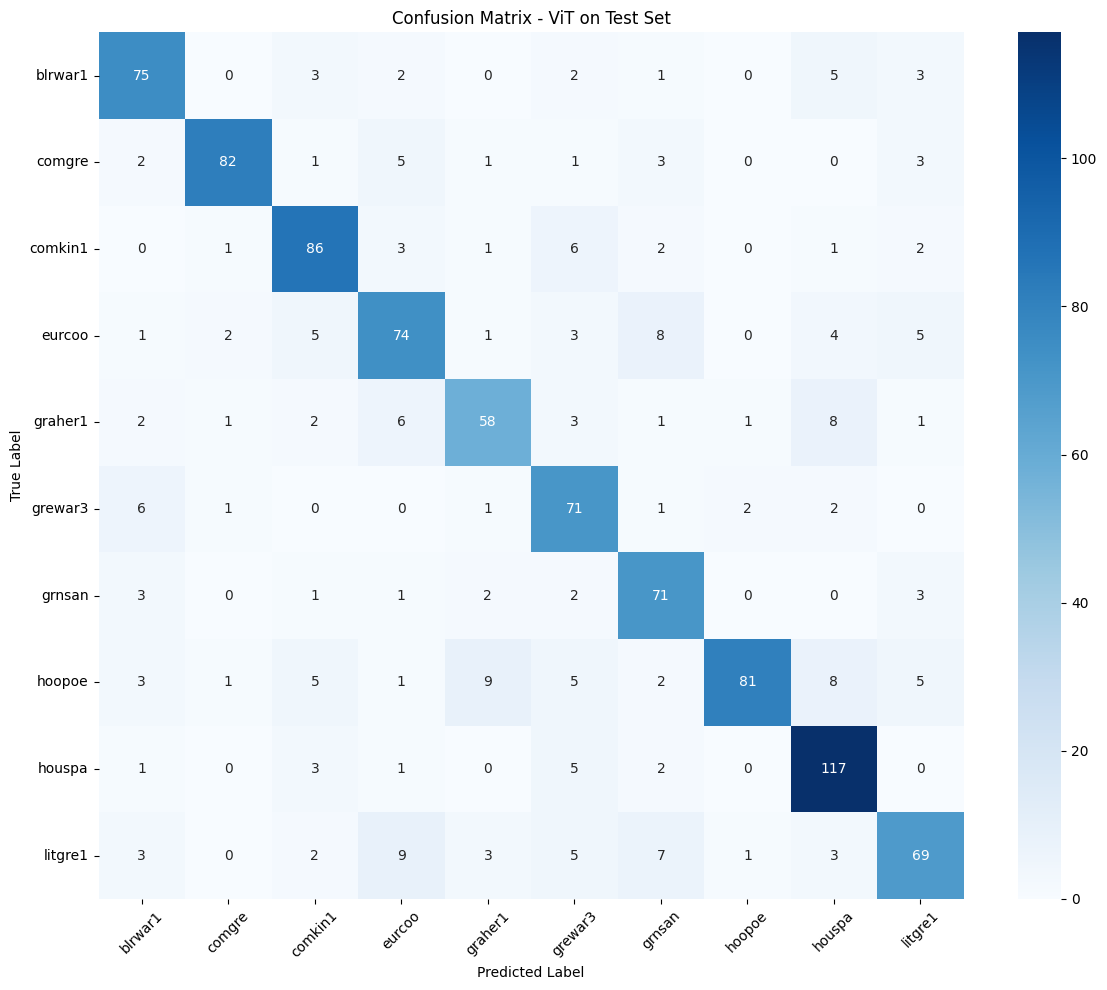

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=target_names,
    yticklabels=target_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - ViT on Test Set")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


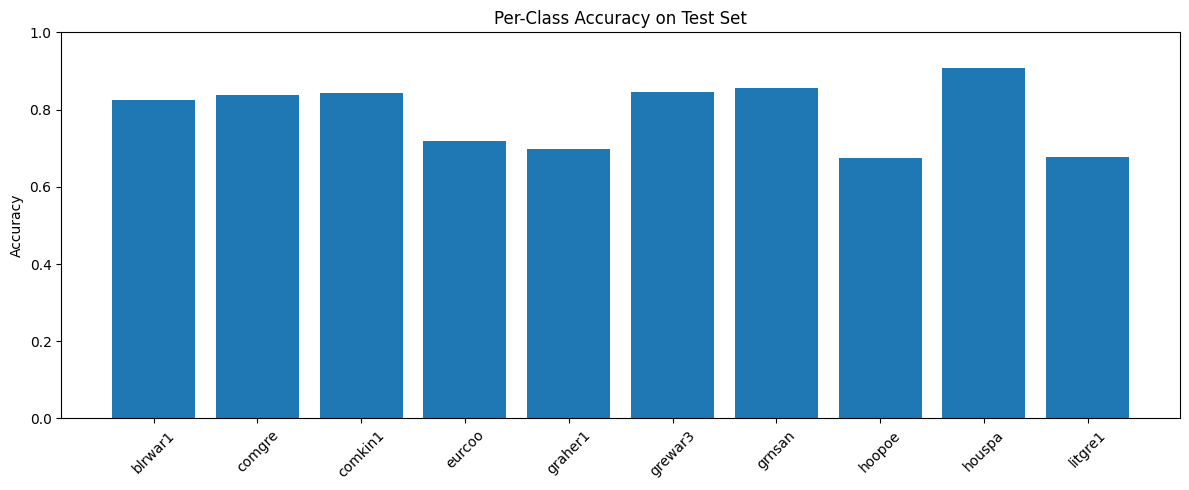

In [34]:
class_correct = {}
class_total = {}

for t, p in zip(all_labels, all_preds):
    label = target_names[t]
    class_total[label] = class_total.get(label, 0) + 1
    if t == p:
        class_correct[label] = class_correct.get(label, 0) + 1

class_acc = {
    c: class_correct.get(c, 0) / class_total[c]
    for c in class_total
}

plt.figure(figsize=(12, 5))
plt.bar(class_acc.keys(), class_acc.values())
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.title("Per-Class Accuracy on Test Set")
plt.tight_layout()
plt.show()


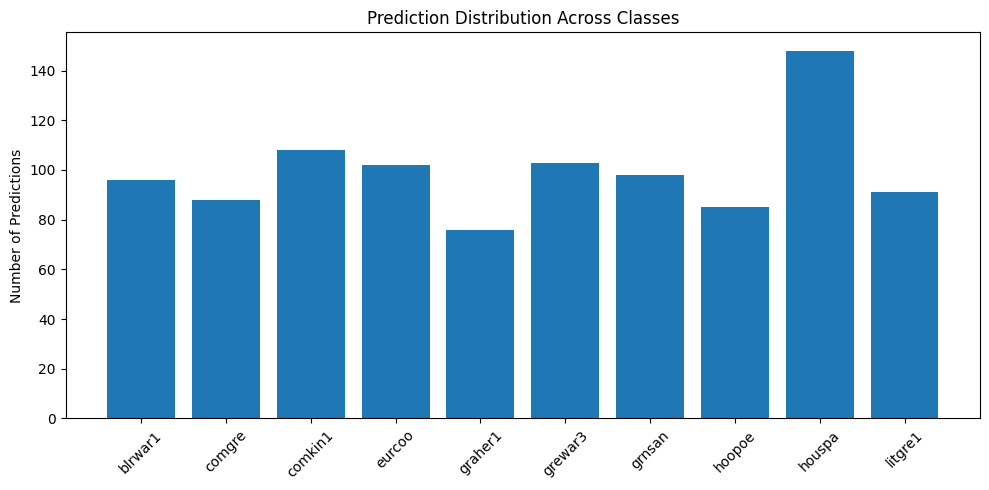

In [35]:
unique, counts = np.unique(all_preds, return_counts=True)
pred_distribution = dict(zip(unique, counts))

labels = [target_names[i] for i in pred_distribution.keys()]
values = pred_distribution.values()

plt.figure(figsize=(10, 5))
plt.bar(labels, values)
plt.xticks(rotation=45)
plt.ylabel("Number of Predictions")
plt.title("Prediction Distribution Across Classes")
plt.tight_layout()
plt.show()


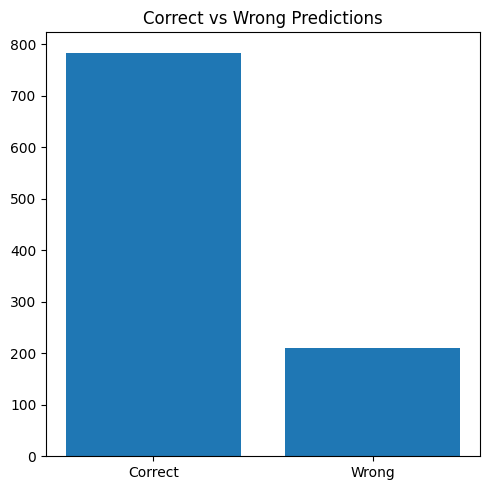

In [36]:
correct = (all_labels == all_preds).sum()
wrong = (all_labels != all_preds).sum()

plt.figure(figsize=(5, 5))
plt.bar(["Correct", "Wrong"], [correct, wrong])
plt.title("Correct vs Wrong Predictions")
plt.tight_layout()
plt.show()


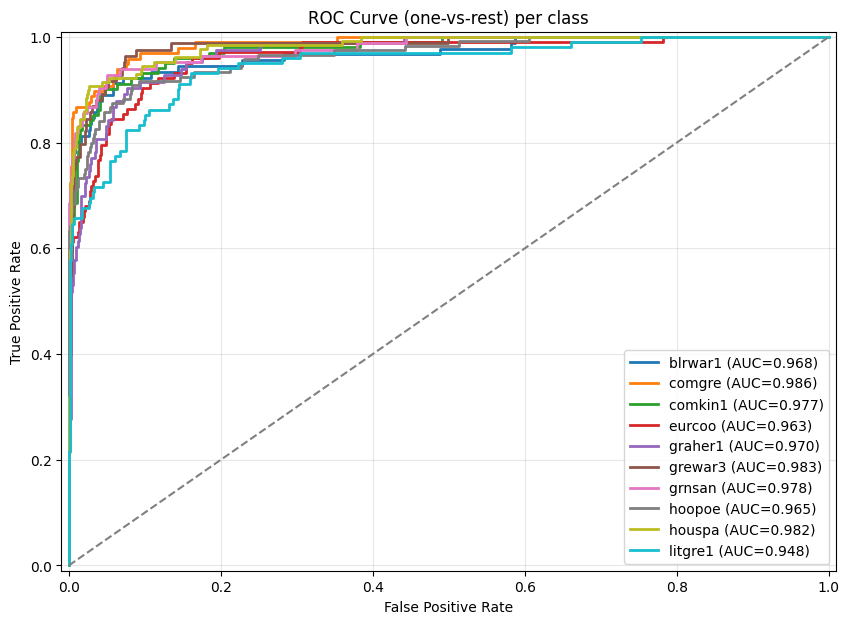

In [38]:
# ====== Plot ROC per-class using cached y_score + y_true ======
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import os
import warnings

score_path = "/kaggle/working/y_score.npy"
true_path  = "/kaggle/working/y_true.npy"

if not (os.path.exists(score_path) and os.path.exists(true_path)):
    raise FileNotFoundError("Cached files not found. Run the inference cell that saves y_score.npy and y_true.npy first.")

y_score = np.load(score_path)   # shape (N, n_classes)
y_true  = np.load(true_path)    # shape (N,)

n_classes = y_score.shape[1]

# get human labels if available
try:
    labels_names = target_names  # from your notebook earlier
except Exception:
    try:
        labels_names = [idx2label[i] for i in range(n_classes)]
    except Exception:
        labels_names = [f"class_{i}" for i in range(n_classes)]

# one-hot encode
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
# in rare case label_binarize returns fewer columns, pad
if y_true_bin.shape[1] != n_classes:
    pad_cols = n_classes - y_true_bin.shape[1]
    if pad_cols > 0:
        y_true_bin = np.hstack([y_true_bin, np.zeros((y_true_bin.shape[0], pad_cols), dtype=int)])

# Plot per-class ROC
plt.figure(figsize=(10, 7))
plotted = False
for i in range(n_classes):
    pos = y_true_bin[:, i].sum()
    if pos == 0:
        warnings.warn(f"Skipping '{labels_names[i]}': no positive examples in test set.")
        continue
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{labels_names[i]} (AUC={roc_auc:.3f})")
    plotted = True

if not plotted:
    print("No ROC curves to plot — none of the classes have positive examples in the test set.")
else:
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (one-vs-rest) per class")
    # if many classes, limit legend size
    if n_classes <= 10:
        plt.legend(loc="lower right")
    else:
        plt.legend(loc="lower right", fontsize="small", ncol=1)
    plt.grid(alpha=0.3)
    plt.show()


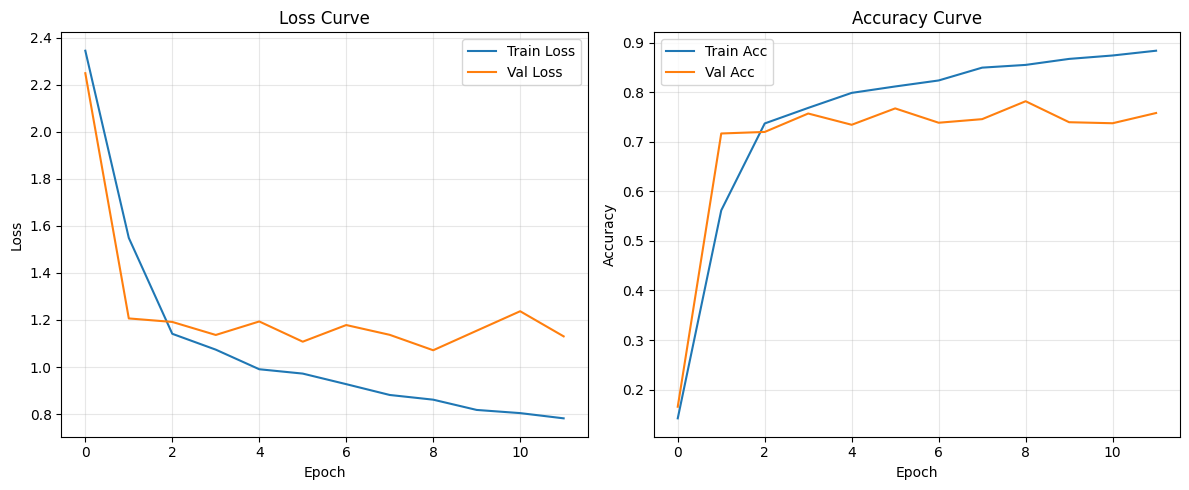

In [39]:
plt.figure(figsize=(12,5))

# ---- Loss Curve ----
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(alpha=0.3)

# ---- Accuracy Curve ----
plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
